# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [609]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [649]:
import random

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier


DATA_PATH_X = '/Users/vasilijdronov/Machine learning/x_spam_train.csv'
DATA_PATH_Y = '/Users/vasilijdronov/Machine learning/y_spam_train.csv'
DATA_PATH_X_test = '/Users/vasilijdronov/Machine learning/x_spam_test.csv'

x_spam_train = pd.read_csv(DATA_PATH_X)
y_spam_train = pd.read_csv(DATA_PATH_Y)
x_spam_test = pd.read_csv(DATA_PATH_X_test)



#Ниже, чтобы проверить, как работают деревья, для дз не нужно
x_train, x_test, y_train, y_test = train_test_split(x_spam_train, y_spam_train, test_size=0.3, random_state = 42)

y_train_ex, y_train_id = list(y_train['Expected']), list(y_train['Id'])
y_test_ex, y_test_id = list(y_test['Expected']), list(y_test['Id'])
del x_train['Id']
del x_test['Id']


In [611]:
#проверка, как работают деревья

from sklearn import tree
tr = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)
tr.fit(x_train, y_train_ex)


pred = tr.predict_proba(x_test)




In [612]:
class RandomForestClassifier:
    def __init__(self, max_depth=None, min_samples_leaf=1, criterion='gini', max_features="auto", n_estimators=10): #заменил критерий
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.n_estimators = n_estimators

    
    def fit(self, X, y):
        self.out_of_bag = []
        self.roots = []
        m = int(X.shape[0]**0.5)
        for i in range(self.n_estimators): 
            if self.max_features == 'auto':
                new_X = X.copy() # надеюсь root после изменения не измениться в массиве
            else:
                new_X = X.sample(n=self.max_features, axis='columns')
            df = new_X.copy()
            df['y'] = y
            dff = df.sample(n=m, replace=True)
            
            self.out_of_bag.append(df.loc[list(df.index.difference(dff.index))]) #добавил почему не работало iloc
            
            
            sub_X = dff
            sub_y = dff['y']
            del sub_X['y']
            root = tree.DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, criterion=self.criterion)
            root.fit(sub_X, sub_y)
            self.roots.append(root)
    
    def predict(self, X):
        flag = True
        for tr in self.roots:
            if flag:
                predictions = pd.DataFrame(tr.predict_proba(X)) #заменил на list + Predict_proba
                flag = False
            else:
                predictions += pd.DataFrame(tr.predict_proba(X))
        predictions /= len(self.roots)
        return predictions

In [613]:
#так как мы перешли на вероятности, функция для перевода в hard-prediction

def to_readable_prediction(X, t):
    ans = []
    for i in range(len(X)):
        if X.iloc[i][1] >= t:
            ans.append(1)
        else:
            ans.append(0)
    return ans

In [614]:
#Проверка как работает лес

tre = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_leaf=3, max_features='auto', n_estimators=100)
tre.fit(x_train, y_train_ex)

pred = tre.predict(x_test)

to_readable_prediction(pred, 0.5)
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(accuracy_score(y_test['Expected'], to_readable_prediction(pred, 0.5)))
print(recall_score(y_test['Expected'], to_readable_prediction(pred, 0.5)))
print(precision_score(y_test['Expected'], to_readable_prediction(pred, 0.5)))




0.8813405797101449
0.7641509433962265
0.9126760563380282


### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [637]:
def pure(X):
    x_copy = X.copy()
    if 'Id' in x_copy.columns:
        del x_copy['Id']
    if 'y' in x_copy.columns:
        del x_copy['y']
    return x_copy

In [638]:
import itertools
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

df = x_spam_train.copy()
df['y'] = y_spam_train['Expected']
df = df.sample(frac=1)
k_rows = int(len(df)/5)
frames = [df.iloc[i*k_rows:(i+1)*k_rows].copy() for i in range(5)] # оставшихся данных нет

        
av_best_auc = 0
hp = None
for i in itertools.product([2, 3, 5, 7, 10],[5, 10, 20, 30, 50, 100]):
    validation = [0,1,2,3]
    av_auc = 0
    for j in range(4):
        validation.remove(j)
        DFT = pd.concat([frames[k] for k in validation])
        tre = RandomForestClassifier(i[0], 4, 'gini', 'auto', i[1])
        tre.fit(pure(DFT), DFT['y'])
        pred = tre.predict(pure(frames[j]))
        auc = roc_auc_score(frames[j]['y'], pred[1])
        av_auc += auc
        validation = [0,1,2,3]
    av_auc /= 4
    if av_auc > av_best_auc:
        av_best_auc = av_auc
        hp = i
print(av_best_auc, hp)

DFT = pd.concat([frames[k] for k in [0,1,2,3]])


tre = RandomForestClassifier(10, 4, 'gini', 'auto', 50)
tre.fit(pure(DFT), DFT['y'])
pred = tre.predict(pure(frames[4]))

print('Accuracy: ', accuracy_score(frames[4]['y'], to_readable_prediction(pred, 0.5)))



        
        

            
                    
        
    

0.9423665298742817 (3, 30)
Accuracy:  0.907608695652174


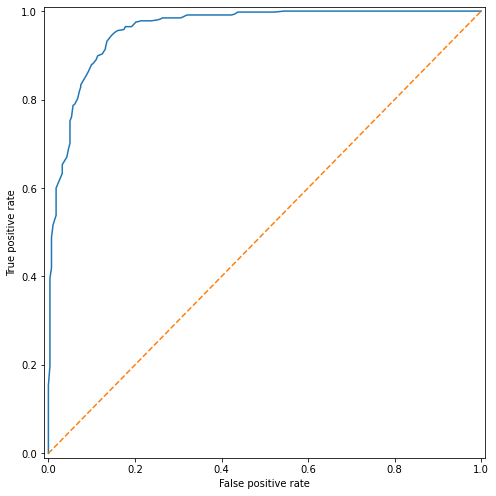

In [639]:
def make_dic(X):
    ans = []
    for i in range(len(pred)):
        ans.append({0:pred.iloc[i][0], 1:pred.iloc[i][1]})
    return ans

#list(frames[4]['y'])

#make_dic(pred)

plot_roc_curve(frames[4]['y'], make_dic(pred))
#print(accuracy_score(frames[4]['y'], to_readable_prediction(pred, 0.5)))
#print(recall_score(frames[4]['y'], to_readable_prediction(pred, 0.5)))
#print(precision_score(frames[4]['y'], to_readable_prediction(pred, 0.5)))



Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [643]:


def feature_importance(rfc):
    ans = [[] for i in range(len(rfc.roots))]
    for i in range(len(rfc.roots)):
        
        pred = rfc.roots[i].predict(pure(rfc.out_of_bag[i]))
        ans[i].append(accuracy_score(rfc.out_of_bag[i]['y'], pred))
        df = rfc.out_of_bag[i].copy()      
        for column in pure(rfc.out_of_bag[i]).columns:
            acc1 = df.copy()
            acc2 = acc1[column].sample(frac=1)
            acc2.index = acc1.index
            acc1[column] = acc2
            pred = rfc.roots[i].predict(pure(acc1))   
            ans[i].append(accuracy_score(rfc.out_of_bag[i]['y'], pred))
        for j in range(1, len(ans[i])):
            ans[i][j] = abs(ans[i][j] - ans[i][0])
    
    for_mean = pd.DataFrame(ans)

    means = list(for_mean.mean())[1:]
    return means
        
    

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [605]:
def to_readable_prediction2(X):
    ans = []
    for row in range(len(X)):
        ans.append(X.loc[row].argmax())
    return ans

def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
print(pd.DataFrame(X))
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(pd.DataFrame(X), pd.DataFrame(y))
pr = rfc.predict(pd.DataFrame(X))

print("Accuracy:", np.mean(to_readable_prediction2(rfc.predict(pd.DataFrame(X))) == y))
print("Importance:", feature_importance(rfc))
print("Importance:", most_important_features(feature_importance(rfc), range(6), k=6))


     0  1  2  3  4  5
0    0  0  0  1  0  1
1    0  0  0  0  0  0
2    0  0  0  0  1  1
3    1  1  1  0  0  0
4    0  0  0  0  0  1
..  .. .. .. .. .. ..
995  1  0  0  0  1  1
996  1  1  0  1  0  0
997  0  1  0  0  0  1
998  1  0  0  0  1  1
999  0  1  1  0  0  1

[1000 rows x 6 columns]
Accuracy: 1.0
Importance: [0.0001031991744066041, 0.00017543859649122752, 0.18925614775331717, 0.19098927679420602, 0.44220066342999453, 5.15995872033026e-05]
Importance: [4 3 2 5 1 0]


In [653]:
forest = RandomForestClassifier(10, 4, 'gini', 'auto', 50)
forest.fit(pure(x_spam_train), pure(y_spam_train))
most_important_features(feature_importance(forest), range(57), k=5)

array([51, 52, 20,  6, 55])

Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

Самые важные: 51, 52, 20, 6, 55(в проядке убывания важности)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [660]:
DATA_PATH_test = '/Users/vasilijdronov/Machine learning/x_spam_test.csv'
test = pd.read_csv(DATA_PATH_test)
test
pred = to_readable_prediction(forest.predict(pure(test)), 0.5)


In [661]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test["Id"]
submission["Expected"] = pred
submission.to_csv('submission.csv', index=False)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

In [662]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 1.2 MB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/vasilijdronov/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.9 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 3.1 MB/s eta 0:00:01    |█████████▌                      | 7.1 MB 2.5 MB/s eta 0:00:07
You should consider upgrading via the '/Users/vasilijdronov/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.2 MB 3.5 MB/s eta 0:00:01     |████████████████                | 614 kB 3.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/vasilijdronov/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [1]:
# YOUR_CODE

_Ваш ответ_